In [1]:
# Import Libraries
import warnings
warnings.filterwarnings(action="ignore")

import os
import numpy as np
import geopandas as gpd
import rasterio as rio  # Ensure rasterio is imported
from rasterio.plot import show as r_show
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score
from tqdm import tqdm
import keras
import matplotlib.pyplot as plt


In [2]:
# File Paths
training_shapefile_path = r"G:\Manjar\github\supervised\signature.shp"
rasters_path = r"G:\Manjar\github\rasterData\clipBands\raster"
classified_path = r"G:\Manjar\github\supervised"

# Create directory if it doesn't exist
os.makedirs(classified_path, exist_ok=True)

# Read Shapefile
training_shapefile = gpd.read_file(training_shapefile_path)
training_shapefile

,Name,geometry
0,Waterbody,POINT (715976.045 3181938.508)
1,Waterbody,POINT (717644.513 3181451.266)
2,Waterbody,POINT (718853.706 3179794.776)
3,Waterbody,POINT (718157.916 3183669.368)
4,Waterbody,POINT (724565.649 3162595.671)
...,...,...
74,Fallow,POINT (694880.863 3162018.036)
75,Fallow,POINT (687755.23 3166375.213)
76,Fallow,POINT (689936.682 3167504.613)
77,Fallow,POINT (687642.594 3159958.714)


In [3]:
print(training_shapefile.columns)


Index(['Name', 'geometry'], dtype='object')


In [4]:
import geopandas as gpd

# File Path for the training shapefile
training_shapefile_path = r"G:\Manjar\github\signatures.shp"

# Read the Shapefile
training_shapefile = gpd.read_file(training_shapefile_path)

# Check the column names
print("Columns in shapefile:", training_shapefile.columns)

# Use 'Name' as the class column
class_column = 'Name'

# Extract and print unique classes
unique_classes = training_shapefile[class_column].unique()
print("Unique classes in the shapefile:")
print(unique_classes)


Columns in shapefile: Index(['Name', 'geometry'], dtype='object')
Unique classes in the shapefile:
['Waterbody' 'Vegetation' 'Built Up' 'Fallow']


In [5]:
# Define class labels
keys = {"Waterbody": 1, "Vegetation": 2, "Built Up": 3, "Fallow": 4}

# Assign labels to the shapefile
training_shapefile["LULC_Class"] = training_shapefile["Name"].apply(lambda x: keys[x])


In [6]:
# Read raster bands
images_nparray = []
images = [item for item in os.listdir(rasters_path) if item.lower().endswith('.tif')]

for raster in images:
    path = os.path.join(rasters_path, raster)
    with rio.open(path) as src:
        band = src.read(1)
        images_nparray.append(band)
images_nparray

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 

In [7]:
# Extract spectral data for each training point
spectral_data = []

for index in tqdm(range(len(training_shapefile)), ncols=100):
    UTM_x, UTM_y = training_shapefile['geometry'][index].x, training_shapefile['geometry'][index].y
    x, y = src.index(UTM_x, UTM_y)
    band_values = [images_nparray[band][y, x] if 0 <= y < images_nparray[band].shape[0] and 0 <= x < images_nparray[band].shape[1] else np.nan for band in range(len(images))]
    spectral_data.append(band_values)

training_shapefile["spectral_data"] = spectral_data
training_shapefile


100%|█████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 5600.14it/s]


,Name,geometry,LULC_Class,spectral_data
0,Waterbody,POINT (129983.012 3185821.531),1,"[nan, nan, nan, nan, nan, nan, nan, nan]"
1,Waterbody,POINT (131626.622 3185250.218),1,"[nan, nan, nan, nan, nan, nan, nan, nan]"
2,Waterbody,POINT (132752.066 3183533.072),1,"[nan, nan, nan, nan, nan, nan, nan, nan]"
3,Waterbody,POINT (132251.83 3187442.007),1,"[nan, nan, nan, nan, nan, nan, nan, nan]"
4,Waterbody,POINT (137597.935 3166050.682),1,"[nan, nan, nan, nan, nan, nan, nan, nan]"
...,...,...,...,...
79,Fallow,POINT (103215.83 3172698.244),4,"[nan, nan, nan, nan, nan, nan, nan, nan]"
80,Fallow,POINT (100542.258 3165265.596),4,"[nan, nan, nan, nan, nan, nan, nan, nan]"
81,Fallow,POINT (104672.808 3165051.927),4,"[nan, nan, nan, nan, nan, nan, nan, nan]"
82,Fallow,POINT (94143.602 3167611.693),4,"[nan, nan, nan, nan, nan, nan, nan, nan]"


In [8]:
# Train-Test Split
train_indices, test_indices, train_data, test_data = [], [], [], []
number_of_classes = 3

for i in range(1, number_of_classes + 1):
    data_class_i = training_shapefile[training_shapefile['LULC_Class'] == i]['spectral_data'].tolist()
    indices_class_i = training_shapefile[training_shapefile['LULC_Class'] == i].index.tolist()

    train_data_list, test_data_list, train_index_list, test_index_list = train_test_split(
        data_class_i, indices_class_i, test_size=0.3, random_state=42
    )

    train_data.extend(train_data_list)
    test_data.extend(test_data_list)
    train_indices.extend(train_index_list)
    test_indices.extend(test_index_list)

# Convert data to numpy arrays
train_data = np.array(train_data)
test_data = np.array(test_data)

# Labels
train_labels = training_shapefile.loc[train_indices, "LULC_Class"].values
test_labels = training_shapefile.loc[test_indices, "LULC_Class"].values


In [9]:
# Random Forest Model
params = {'max_depth': 50, 'n_estimators': 200, 'random_state': 10, 'min_samples_split': 10}
rf_classifier = RandomForestClassifier(**params)
rf_classifier.fit(train_data, train_labels)

# Predict
prediction = rf_classifier.predict(test_data)

# Metrics
accuracy = accuracy_score(test_labels, prediction)
kappa = cohen_kappa_score(test_labels, prediction)

print(f"Model's Accuracy: {accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")


Model's Accuracy: 0.3636
Cohen's Kappa: 0.0000


In [10]:
# Classify raster
rows, cols = images_nparray[0].shape
rf_predictions = np.zeros((rows, cols), dtype=np.uint8)

for row in tqdm(range(rows), desc="Classifying Rows", ncols=100):
    spectral_data_row = [images_nparray[band][row, :] for band in range(len(images))]
    spectral_data_row = np.transpose(np.array(spectral_data_row))
    predictions = rf_classifier.predict(spectral_data_row)
    rf_predictions[row, :] = predictions


Classifying Rows: 100%|█████████████████████████████████████████| 1751/1751 [00:18<00:00, 96.97it/s]


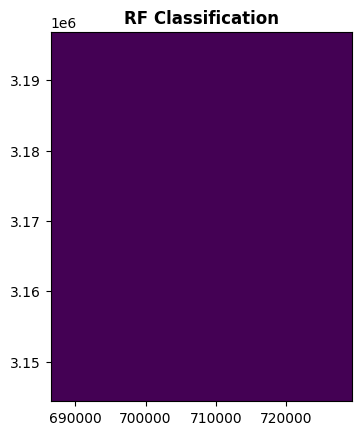

In [11]:
# Save Classified Raster
out_meta = src.meta.copy()
out_meta.update(dtype=rio.uint8, count=1)

classified_raster_path = os.path.join(classified_path, "rf_classified.tif")

with rio.open(classified_raster_path, "w", **out_meta) as dst:
    dst.write(rf_predictions, 1)

# Visualize
with rio.open(classified_raster_path) as dataset:
    r_show(dataset, title="RF Classification")
